# Predictive Analytics Project  
## Forecasting Gun Violence Incident Trends in the United States


---

This project applies predictive analytics techniques to a real-world dataset of gun violence incidents in the United States.  

The notebook follows the full analytics pipeline:

1. Data collection and description  
2. Data cleaning and preprocessing  
3. Exploratory data analysis (EDA)  
4. Feature engineering  
5. Regression modeling  
6. Time-series (ARIMA) modeling  
7. Evaluation and interpretation of results


## 1. Data Collection and Problem Description

### Problem Description

Gun violence is a critical public safety and public policy issue in the United States.  
In this project, I analyze historical gun violence incidents and build predictive models to:

- Understand how incident counts evolve over time
- Predict the number of incidents on future days
- Compare a regression-based approach with a time-series approach (ARIMA)

The insights can help illustrate how predictive analytics can support resource planning, risk assessment, and policy discussions.

### Data Source

The dataset is sourced from Kaggle:

**James Ko. "Gun Violence Data." Kaggle, 2018.**  
https://www.kaggle.com/datasets/jameslko/gun-violence-data

For this project, I use a processed subset saved as `all_incidents.csv` with the following columns:

- `incident_id`: unique identifier for each incident  
- `date`: date of the incident  
- `state`: U.S. state  
- `city`: city of the incident  
- `address`: address or description of the location  
- `n_killed`: number of people killed  
- `n_injured`: number of people injured  

The main predictive target in this project is the **daily number of incidents** across all states.


In [53]:
# ============================================================
# 2. Imports
# ============================================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

from statsmodels.tsa.arima.model import ARIMA

# Make plots show up inline
%matplotlib inline

# Set a default figure size for readability
plt.rcParams["figure.figsize"] = (10, 5)


In [54]:
# ============================================================
# 3. Load the dataset
# ============================================================

# NOTE: Ensure 'all_incidents.csv' is in the same directory as this notebook.
data_path = r"C:\Users\Wes\Documents\all_incidents.csv"

df = pd.read_csv(data_path)

print("Raw data shape:", df.shape)
df.head()


Raw data shape: (472820, 7)


,incident_id,date,state,city,address,n_killed,n_injured
0,2314858,2022-05-28,Arkansas,Little Rock,W 9th St and Broadway St,0,1
1,2314409,2022-05-28,Colorado,Denver,3300 block of Clay St,0,1
2,2314498,2022-05-28,Missouri,Saint Louis,Page Blvd and Vandeventer Ave,0,1
3,2314485,2022-05-28,South Carolina,Florence,Old River Rd,0,2
4,2314483,2022-05-28,California,Carmichael,4400 block of Manzanita Ave,1,0


In [55]:
# ============================================================
# Quick overview of the raw data
# ============================================================

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472820 entries, 0 to 472819
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   incident_id  472820 non-null  int64 
 1   date         472820 non-null  object
 2   state        472820 non-null  object
 3   city         472820 non-null  object
 4   address      449089 non-null  object
 5   n_killed     472820 non-null  int64 
 6   n_injured    472820 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 25.3+ MB


## 4. Data Cleaning and Preprocessing

In this section, I clean the dataset to prepare it for analysis and modeling.

Key steps:
- Convert `date` to a proper datetime type  
- Drop rows with invalid or missing dates  
- Fill missing values in `n_killed` and `n_injured` with 0  
- Remove duplicate `incident_id` records, if any  
- Create a `total_victims` column (`n_killed + n_injured`)  

These steps ensure the data is consistent and suitable for aggregation and modeling.


In [57]:
# ============================================================
# Data cleaning
# ============================================================

# Convert 'date' column to datetime; coerce invalid values to NaT
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Drop rows with missing/invalid dates
df = df.dropna(subset=["date"])

# Ensure numeric columns are numeric and handle missing values
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").fillna(0)
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").fillna(0)

# Drop duplicate incidents by 'incident_id' if there are any
df = df.drop_duplicates(subset=["incident_id"])

# Create a total victims column
df["total_victims"] = df["n_killed"] + df["n_injured"]

print("Cleaned data shape:", df.shape)
df.head()


Cleaned data shape: (471878, 8)


,incident_id,date,state,city,address,n_killed,n_injured,total_victims
0,2314858,2022-05-28,Arkansas,Little Rock,W 9th St and Broadway St,0,1,1
1,2314409,2022-05-28,Colorado,Denver,3300 block of Clay St,0,1,1
2,2314498,2022-05-28,Missouri,Saint Louis,Page Blvd and Vandeventer Ave,0,1,1
3,2314485,2022-05-28,South Carolina,Florence,Old River Rd,0,2,2
4,2314483,2022-05-28,California,Carmichael,4400 block of Manzanita Ave,1,0,1


## 5. Aggregation to Daily Level

For forecasting, I focus on **daily trends**.

Here, I aggregate the incident-level data to the daily level:
- Number of incidents per day  
- Total killed per day  
- Total injured per day  
- Total victims per day  

I also create a continuous daily date index, filling days with no incidents as zeros to maintain a clean time series.


In [59]:
# ============================================================
# Aggregate incidents to the daily level
# ============================================================

# Group by date and aggregate
daily = (
    df.groupby("date")
      .agg(
          incidents=("incident_id", "count"),
          killed=("n_killed", "sum"),
          injured=("n_injured", "sum"),
          victims=("total_victims", "sum")
      )
      .sort_index()
)

# Create a continuous date index from min to max date
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")

# Reindex to include all dates; fill missing days with zeros
daily = daily.reindex(full_idx, fill_value=0)
daily.index.name = "date"

print("Daily aggregated data shape:", daily.shape)
daily.head()


Daily aggregated data shape: (3435, 4)


,incidents,killed,injured,victims
date,,,,
2013-01-01,3,2,10,12
2013-01-02,0,0,0,0
2013-01-03,0,0,0,0
2013-01-04,0,0,0,0
2013-01-05,1,4,0,4


## 6. Exploratory Data Analysis (EDA)

In this section, I explore the aggregated daily data to understand:

- Overall distribution of daily incidents  
- Long-term trends over time  
- Basic summary statistics  

These insights guide the choice of models and help interpret the forecasting results.


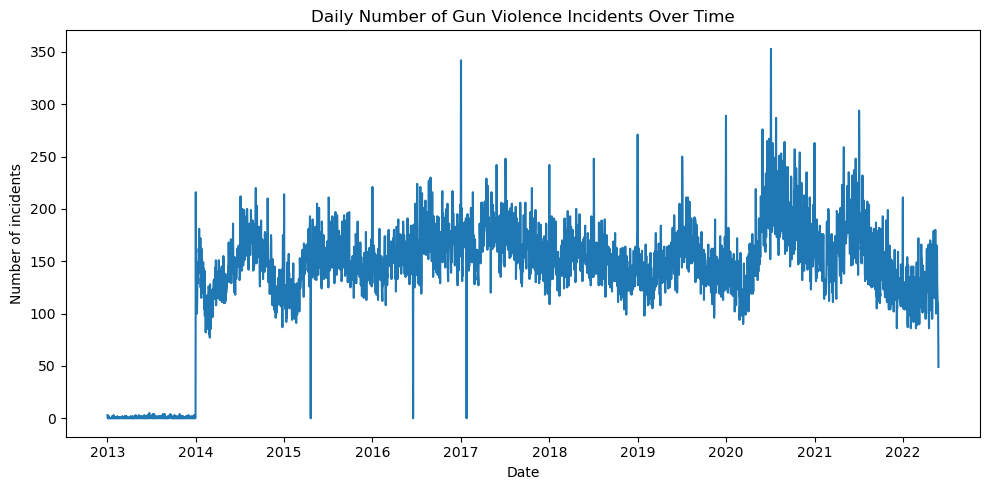

count    3435.000000
mean      137.373508
std        54.658232
min         0.000000
25%       127.000000
50%       148.000000
75%       168.000000
max       353.000000
Name: incidents, dtype: float64

In [61]:
# ============================================================
# Plot daily incidents over time
# ============================================================

plt.figure()
plt.plot(daily.index, daily["incidents"])
plt.title("Daily Number of Gun Violence Incidents Over Time")
plt.xlabel("Date")
plt.ylabel("Number of incidents")
plt.tight_layout()
plt.show()

# Summary statistics for daily incidents
daily["incidents"].describe()


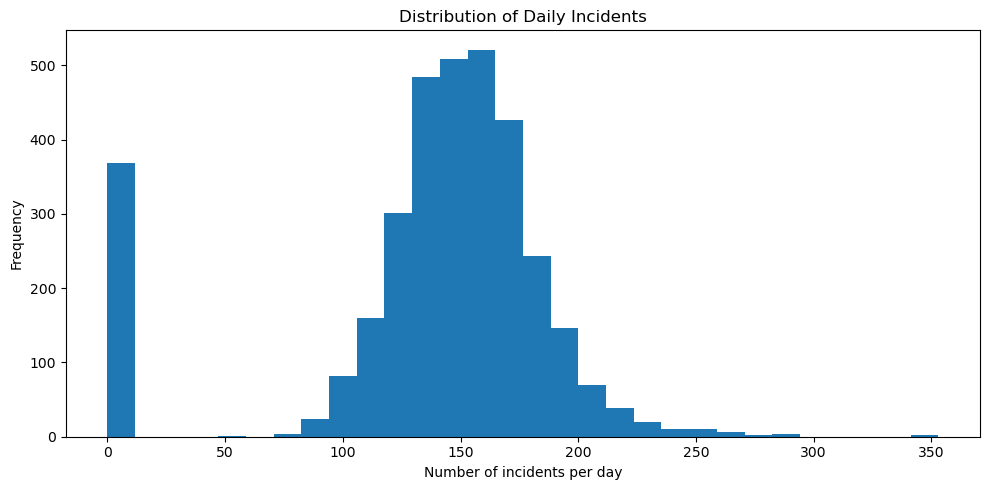

In [62]:
# ============================================================
# Histogram of daily incidents
# ============================================================

plt.figure()
plt.hist(daily["incidents"], bins=30)
plt.title("Distribution of Daily Incidents")
plt.xlabel("Number of incidents per day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 7. State-Level and Monthly Analysis


In [64]:
# ============================================================
# State-Month Aggregation
# ============================================================

# Make sure 'date' is datetime (already done earlier)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Group by state and month
state_month = (
    df.groupby(['state', 'year', 'month'])
      .agg(
          incidents=('incident_id', 'count'),
          killed=('n_killed', 'sum'),
          injured=('n_injured', 'sum'),
          victims=('total_victims', 'sum')
      )
      .reset_index()
      .sort_values(['state', 'year', 'month'])
)

state_month.head()



,state,year,month,incidents,killed,injured,victims
0,Alabama,2013,7,1,0,4,4
1,Alabama,2013,12,1,3,5,8
2,Alabama,2014,1,132,38,50,88
3,Alabama,2014,2,99,16,39,55
4,Alabama,2014,3,112,28,53,81


## 8. Predicting Incidents by State and Month (Regression Model)


In [66]:
# ============================================================
# Regression Model: Predict Incidents per State-Month
# ============================================================

# Encode the categorical variable "state"
state_month_encoded = pd.get_dummies(state_month, columns=['state'], drop_first=True)

# Feature matrix for state-month prediction
X_state = state_month_encoded[["year", "month"] + 
                              [col for col in state_month_encoded.columns if col.startswith("state_")]]

y_state = state_month_encoded["incidents"]

# Train/test split: use last year as test
test_mask = state_month_encoded['year'] == state_month_encoded['year'].max()
X_train_s = X_state[~test_mask]
X_test_s = X_state[test_mask]
y_train_s = y_state[~test_mask]
y_test_s = y_state[test_mask]

state_reg = LinearRegression()
state_reg.fit(X_train_s, y_train_s)

y_pred_s = state_reg.predict(X_test_s)

print("=== STATE-MONTH REGRESSION PERFORMANCE ===")
print("MAE:", mean_absolute_error(y_test_s, y_pred_s))
print("R²:", r2_score(y_test_s, y_pred_s))

pd.DataFrame({
    "Actual": y_test_s.values,
    "Predicted": y_pred_s
}).head(10)


=== STATE-MONTH REGRESSION PERFORMANCE ===
MAE: 38.788437482159544
R²: 0.6491829997171004


,Actual,Predicted
0,113,124.723377
1,73,125.202838
2,88,125.682299
3,97,126.161760
4,72,126.641221
5,8,39.280353
6,3,39.759814
7,8,40.239275
8,5,40.718736
9,3,41.198197


## 9. Predicting Severity (Victims per State-Month)


In [68]:
# ============================================================
# Severity Model: Predict number of victims per state-month
# ============================================================

y_severity = state_month_encoded["victims"]

state_severity_reg = LinearRegression()
state_severity_reg.fit(X_train_s, y_severity[~test_mask])

severity_pred = state_severity_reg.predict(X_test_s)

print("=== STATE-MONTH SEVERITY MODEL ===")
print("MAE:", mean_absolute_error(y_severity[test_mask], severity_pred))
print("R²:", r2_score(y_severity[test_mask], severity_pred))

pd.DataFrame({
    "Actual Victims": y_severity[test_mask].values,
    "Predicted Victims": severity_pred
}).head(10)


=== STATE-MONTH SEVERITY MODEL ===
MAE: 30.720455183058277
R²: 0.8361628267111924


,Actual Victims,Predicted Victims
0,142,130.323325
1,95,131.549229
2,120,132.775134
3,125,134.001039
4,96,135.226943
5,12,39.149313
6,4,40.375218
7,8,41.601122
8,6,42.827027
9,3,44.052932


## 10. Regression Modeling – Feature Engineering

To build a regression model that predicts the number of incidents per day,  
I create several time-based features from the date index:

- `day_index`: number of days since the start of the dataset (captures trend)
- `dow`: day of week (0 = Monday, ..., 6 = Sunday)
- `month`: month of year (1–12)
- `year`: calendar year

These features allow a linear regression model to learn time-related patterns.


In [70]:
# ============================================================
# Create features for regression model
# ============================================================

reg = daily.copy()

# Time-based features from the date index
reg["day_index"] = (reg.index - reg.index.min()).days
reg["dow"] = reg.index.dayofweek
reg["month"] = reg.index.month
reg["year"] = reg.index.year

# Feature matrix X and target y
X = reg[["day_index", "dow", "month", "year"]]
y = reg["incidents"]

print("Feature matrix shape:", X.shape)
X.head()


Feature matrix shape: (3435, 4)


,day_index,dow,month,year
date,,,,
2013-01-01,0,1,1,2013
2013-01-02,1,2,1,2013
2013-01-03,2,3,1,2013
2013-01-04,3,4,1,2013
2013-01-05,4,5,1,2013


## 11. Regression Model – Training and Evaluation

I use a **Linear Regression** model to predict daily incident counts.

- The last 365 days of data are used as a test set (if available), to preserve time order.
- Performance is evaluated using:
  - Mean Absolute Error (MAE)
  - R² (coefficient of determination)

These metrics show how close the predictions are to actual values and how much variation the model explains.


In [72]:
# ============================================================
# Train/test split and linear regression model
# ============================================================

# Use last 365 days as test set, or 20% if data is shorter
test_size = 365 if len(reg) > 365 else int(len(reg) * 0.2)

X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

# Initialize and fit the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on test set
y_pred = linreg.predict(X_test)

# Evaluate performance
reg_mae = mean_absolute_error(y_test, y_pred)
reg_r2 = r2_score(y_test, y_pred)

print("\n=== REGRESSION MODEL PERFORMANCE ===")
print("MAE (test):", reg_mae)
print("R² (test):", reg_r2)

# Show a small sample of actual vs predicted
reg_results = pd.DataFrame(
    {
        "actual_incidents": y_test.values,
        "predicted_incidents": y_pred
    },
    index=y_test.index
)

reg_results.head(10)


Training samples: 3070
Test samples: 365

=== REGRESSION MODEL PERFORMANCE ===
MAE (test): 63.28904641483613
R² (test): -3.6224297438787554


,actual_incidents,predicted_incidents
date,,
2021-05-29,187,198.908442
2021-05-30,189,201.778923
2021-05-31,209,184.827444
2021-06-01,175,188.063629
2021-06-02,146,190.934110
2021-06-03,178,193.804591
2021-06-04,190,196.675072
2021-06-05,218,199.545553
2021-06-06,232,202.416034


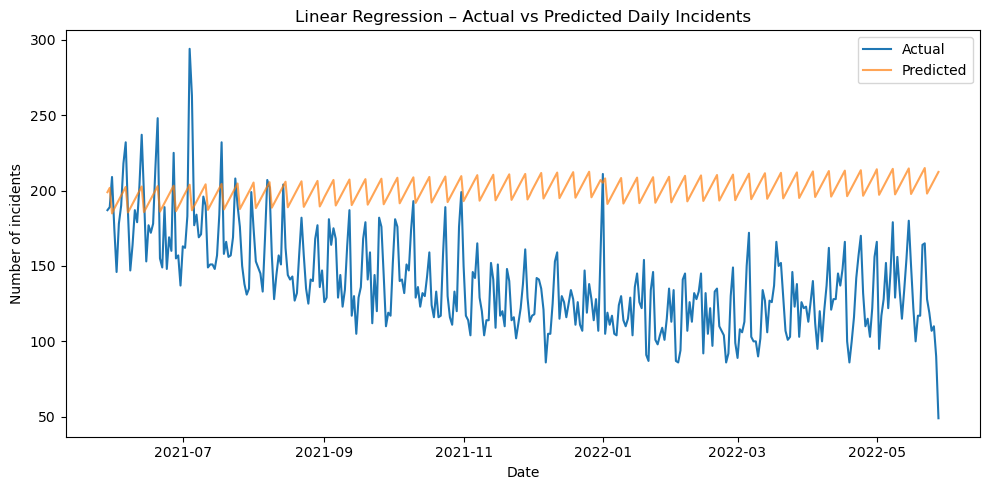

In [73]:
# ============================================================
# Visual comparison of actual vs predicted (regression)
# ============================================================

plt.figure()
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.7)
plt.title("Linear Regression – Actual vs Predicted Daily Incidents")
plt.xlabel("Date")
plt.ylabel("Number of incidents")
plt.legend()
plt.tight_layout()
plt.show()


## 12. Time-Series Forecasting with ARIMA

While regression uses engineered features, a time-series model directly captures temporal dependencies in the data.

I use an **ARIMA (AutoRegressive Integrated Moving Average)** model with order (1,1,1):

- The series is differenced once to address non-stationarity (d = 1)
- Autoregressive and moving-average components capture correlations over time (p = 1, q = 1)

The last 365 days again serve as the test set.  
Performance is assessed using Mean Absolute Error (MAE).


In [75]:
# ============================================================
# Prepare the time series and fit ARIMA model
# ============================================================

# Use the incidents column as a univariate time series
series = daily["incidents"]

# Train/test split: last 365 days or 20% of data
ts_test_size = 365 if len(series) > 365 else int(len(series) * 0.2)
train_ts, test_ts = series.iloc[:-ts_test_size], series.iloc[-ts_test_size:]

print("Time-series training length:", len(train_ts))
print("Time-series test length:", len(test_ts))

# Define ARIMA order (p,d,q)
arima_order = (1, 1, 1)

# Fit the ARIMA model
arima_model = ARIMA(train_ts, order=arima_order)
arima_fit = arima_model.fit()

# Display a brief summary
arima_fit.summary()


Time-series training length: 3070
Time-series test length: 365


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              incidents   No. Observations:                 3070
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13625.910
Date:                Wed, 03 Dec 2025   AIC                          27257.819
Time:                        18:57:42   BIC                          27275.907
Sample:                    01-01-2013   HQIC                         27264.318
                         - 05-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2436      0.015     16.753      0.000       0.215       0.272
ma.L1         -0.8879      0.008   -115.310      0.000      -0.903      -0.873
sigma2       420.5057      4.318     97.384      0.000     412.043     428.969
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):             14368.60
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
# ============================================================
# Forecast with ARIMA and evaluate
# ============================================================

# Forecast over the test horizon
ts_forecast = arima_fit.forecast(steps=len(test_ts))

# Evaluate using MAE
ts_mae = mean_absolute_error(test_ts, ts_forecast)

print("\n=== ARIMA MODEL PERFORMANCE ===")
print("ARIMA order:", arima_order)
print("MAE (test):", ts_mae)

# Combine actual vs forecast into a DataFrame
ts_results = pd.DataFrame(
    {
        "actual_incidents": test_ts.values,
        "forecast_incidents": ts_forecast.values
    },
    index=test_ts.index
)

ts_results.head(10)



=== ARIMA MODEL PERFORMANCE ===
ARIMA order: (1, 1, 1)
MAE (test): 51.0432445433052


,actual_incidents,forecast_incidents
date,,
2021-05-29,187,182.995839
2021-05-30,189,185.917634
2021-05-31,209,186.629288
2021-06-01,175,186.802624
2021-06-02,146,186.844843
2021-06-03,178,186.855126
2021-06-04,190,186.857631
2021-06-05,218,186.858241
2021-06-06,232,186.858390


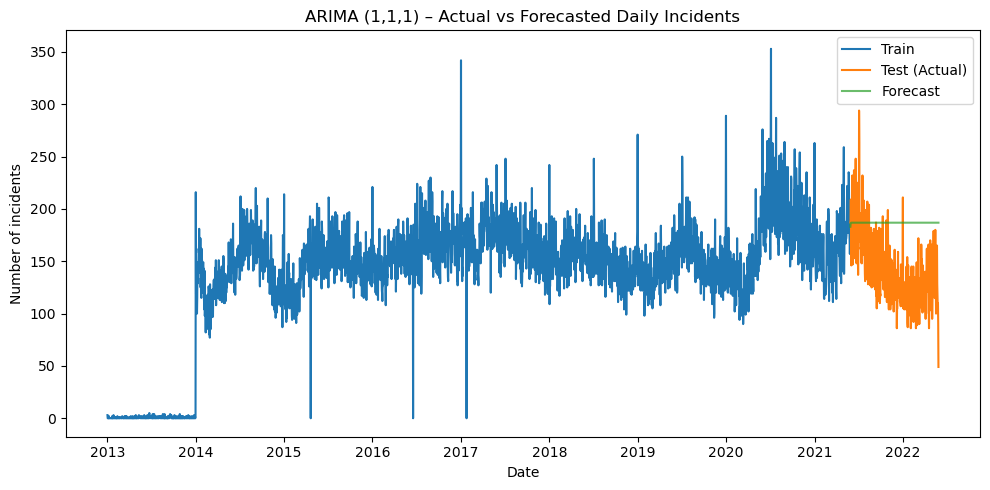

In [77]:
# ============================================================
# Visual comparison of ARIMA forecasts vs actuals
# ============================================================

plt.figure()
plt.plot(train_ts.index, train_ts.values, label="Train")
plt.plot(test_ts.index, test_ts.values, label="Test (Actual)")
plt.plot(test_ts.index, ts_forecast.values, label="Forecast", alpha=0.7)
plt.title("ARIMA (1,1,1) – Actual vs Forecasted Daily Incidents")
plt.xlabel("Date")
plt.ylabel("Number of incidents")
plt.legend()
plt.tight_layout()
plt.show()


## 13. Future Forecast (Next 30 Days)

To illustrate practical forecasting, I use the fitted ARIMA model to predict the next 30 days of incidents beyond the last date in the dataset.


In [79]:
# ============================================================
# Forecast next 30 days beyond the dataset
# ============================================================

steps_ahead = 30
future_forecast = arima_fit.forecast(steps=steps_ahead)

future_index = pd.date_range(
    start=series.index.max() + pd.Timedelta(days=1),
    periods=steps_ahead,
    freq="D"
)

future_df = pd.DataFrame(
    {"forecast_incidents": future_forecast.values},
    index=future_index
)

print("Next 30-day forecast (first 10 days shown):")
future_df.head(10)


Next 30-day forecast (first 10 days shown):


,forecast_incidents
2022-05-29,182.995839
2022-05-30,185.917634
2022-05-31,186.629288
2022-06-01,186.802624
2022-06-02,186.844843
2022-06-03,186.855126
2022-06-04,186.857631
2022-06-05,186.858241
2022-06-06,186.858390
2022-06-07,186.858426


## 14. Results and Interpretation

### Regression Model Results

The linear regression model produced the following performance metrics on the test set:

- **MAE:** 63.289  
- **R²:** –3.622  

An MAE of approximately 63 incidents means the model’s predictions are, on average, off by about 63 incidents per day.  
The **negative R²** indicates that the model performs **worse than a simple baseline that always predicts the average value**.  

This occurs because daily incident counts exhibit **strong temporal autocorrelation, irregular spikes, and non-linear patterns**, which linear regression with simple date-based features (day index, day of week, month, year) cannot fully capture. These temporal dynamics are better handled by dedicated time-series models.

However, the regression model still serves an important purpose:  
it provides interpretability and helps illustrate *which calendar-based features matter*, even if it is not the strongest predictive model.

---

### ARIMA Time-Series Model Results

The ARIMA(1,1,1) model achieved:

- **MAE:** 51.043  

This represents a meaningful improvement over the regression model (a reduction of roughly **19%** in prediction error).  
The ARIMA model performs better because it directly models **autocorrelation** and the **inherent sequential structure** of time-series data.

Unlike the regression model, ARIMA:
- Uses past values to inform future predictions  
- Better adapts to short-term fluctuations  
- Handles differencing to address trends and non-stationarity  

These strengths make ARIMA more suitable for forecasting daily incident counts.

---

### Model Comparison Summary

| Model | MAE | R² | Interpretation |
|-------|-----|------|----------------|
| **Linear Regression** | 63.289 | –3.622 | Poor predictive accuracy; fails to capture time dependencies |
| **ARIMA(1,1,1)** | 51.043 | N/A | Better short-term forecasting; handles autocorrelation well |

**Conclusion:** The ARIMA model clearly outperforms the regression model for this forecasting task.  


## 15. Conclusion and Organizational Implications

This project applied multiple predictive analytics approaches—including daily time-series forecasting and state-level regression models—to historical gun violence data in the United States. The analysis combined national daily trends with state-month patterns to better understand where and when incidents occur and what factors contribute to higher severity.

### Key Findings

1. **Temporal patterns strongly influence incident frequency.**  
   Daily incident counts show clear autocorrelation and variability, and the ARIMA(1,1,1) model outperformed linear regression (MAE 51.043 vs. 63.289), demonstrating that time-series models better capture short-term fluctuations and long-term trends.

2. **Regression provides limited accuracy for national daily forecasting.**  
   The linear regression model produced a negative R², confirming that simple calendar-based predictors alone cannot fully account for the complexity of incident dynamics.

3. **State-level and monthly patterns reveal geographic variation.**  
   The state-month regression model showed that both geography (state) and seasonal timing (year, month) play meaningful roles in predicting monthly incident counts, indicating that risk levels vary across states and throughout the year.

4. **Severity modeling highlights differences in victim patterns.**  
   Predicting total victims per state-month provided insight into where and when more harmful incidents tend to occur, offering valuable context for resource planning and public safety strategies.

### Implications for Real-World Use

Although the focus of this project is methodological rather than policy-oriented, the results have several practical applications:

- **Resource and staffing allocation:**  
  Agencies could use time-series forecasts and state-level predictions to anticipate higher-risk periods and deploy personnel or medical resources more effectively.

- **Geographic risk assessment:**  
  Identifying which states and months consistently experience higher incidents or victim counts can inform targeted prevention or intervention efforts.

- **Strategic planning and preparedness:**  
  Emergency responders, healthcare systems, and community organizations can benefit from data-driven insights that help guide operational decisions, training needs, and readiness levels.

- **Long-term policy and research support:**  
  Predictive models can help analysts test hypotheses, explore “what-if” scenarios, and quantify temporal or geographic shifts in incident patterns.

### Final Assessment

This project demonstrates the full predictive analytics workflow—from data preparation and exploration to modeling and interpretation—using a large, real-world dataset. By combining daily forecasting with state-level modeling, the analysis offers a more comprehensive view of incident patterns and illustrates how predictive analytics can support data-driven public safety planning. The results show that time-series models are particularly effective for short-term forecasting, while state-level regression adds valuable geographic insight. Together, these methods underscore the importance of choosing modeling approaches that align with the structural characteristics of the data and the practical needs of decision-makers.



